In [1]:
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import json

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [2]:
# Parameters
CELL_TYPE = "SHSY5Y"
CONTROL_NAME = "DMSO_0.100_%_DMSO_0.025_%"
TREATMENT_NAME = "LPS_100.000_ug_per_ml_DMSO_0.025_%"
MODEL_NAME = "DMSO_0.025_vs_LPS_100"
SHUFFLE = True

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/binary_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [5]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_%_DMSO_0.025_%' 'LPS_100.000_ug_per_ml_DMSO_0.025_%']
The dimensions of the data are: (51630, 1276)
Number of total missing values across all columns: 0
Data Subset Is Off


In [6]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'J21']
Wells to use for training, validation, and testing ['B14' 'C14' 'B15' 'C15' 'J14' 'I15' 'J15' 'J16' 'J17' 'J20']


In [7]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [8]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [9]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=mlp_params.TRAIN_PROPORTION_SPLIT,
    val_proportion=mlp_params.VALIDATION_PROPORTION_SPLIT,
    test_proportion=mlp_params.TEST_PROPORTION_SPLIT,
    # train_proportion=0.8,
    # val_proportion=0.1,
    # test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [10]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [11]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  2
Binary_Classification


In [12]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [13]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.386064).  Saving model ...
	 Train_Loss: 0.5069 Train_Acc: 77.702 Val_Loss: 0.3861  BEST VAL Loss: 0.3861  Val_Acc: 87.368

Epoch 1: Validation loss decreased (0.386064 --> 0.343327).  Saving model ...
	 Train_Loss: 0.4357 Train_Acc: 85.756 Val_Loss: 0.3433  BEST VAL Loss: 0.3433  Val_Acc: 90.532

Epoch 2: Validation loss decreased (0.343327 --> 0.314406).  Saving model ...
	 Train_Loss: 0.3930 Train_Acc: 87.704 Val_Loss: 0.3144  BEST VAL Loss: 0.3144  Val_Acc: 91.938

Epoch 3: Validation loss decreased (0.314406 --> 0.291083).  Saving model ...
	 Train_Loss: 0.3628 Train_Acc: 89.213 Val_Loss: 0.2911  BEST VAL Loss: 0.2911  Val_Acc: 93.508

Epoch 4: Validation loss decreased (0.291083 --> 0.271966).  Saving model ...
	 Train_Loss: 0.3399 Train_Acc: 90.156 Val_Loss: 0.2720  BEST VAL Loss: 0.2720  Val_Acc: 94.118

Epoch 5: Validation loss decreased (0.271966 --> 0.258071).  Saving model ...
	 Train_Loss: 0.3219 Train_Acc: 90.941 Val_Loss:

In [14]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "treatments_tested",
        "model",
        "group",
        "shuffled_data",
        "PR_Threshold",
        "Precision",
        "Recall",
    ]
)
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1001: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1002: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


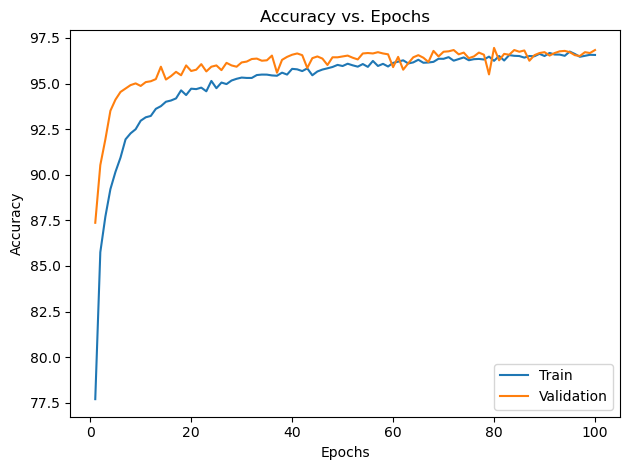

In [15]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1001: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1002: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


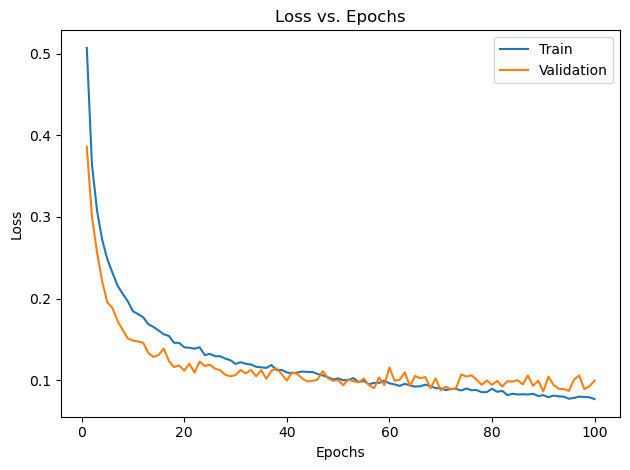

In [16]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

In [17]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_LPS_100_shuffle


In [18]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     24644
           1       0.28      0.28      0.28      9489

    accuracy                           0.60     34133
   macro avg       0.50      0.50      0.50     34133
weighted avg       0.60      0.60      0.60     34133



In [19]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [20]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_LPS_100_shuffle


In [21]:
mlp_params.SHUFFLE

True

In [22]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_validation",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      3081
           1       0.27      0.27      0.27      1186

    accuracy                           0.59      4267
   macro avg       0.49      0.49      0.49      4267
weighted avg       0.59      0.59      0.59      4267



In [23]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_1708492/426878485.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [24]:
mlp_params.MODEL_NAME

'DMSO_0.025_vs_LPS_100'

In [25]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_LPS_100_shuffle


              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3081
           1       0.27      0.27      0.27      1186

    accuracy                           0.60      4267
   macro avg       0.50      0.50      0.50      4267
weighted avg       0.60      0.60      0.60      4267



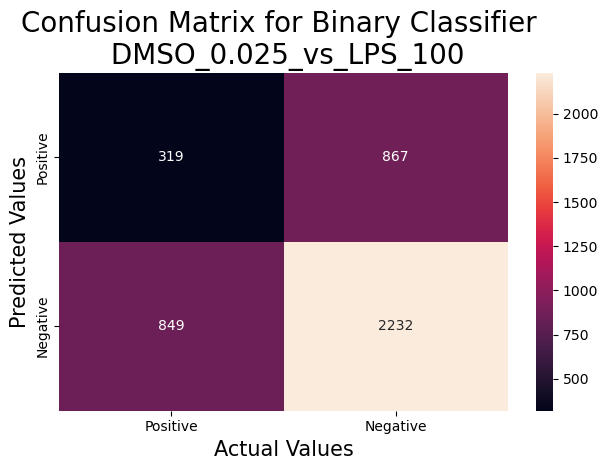

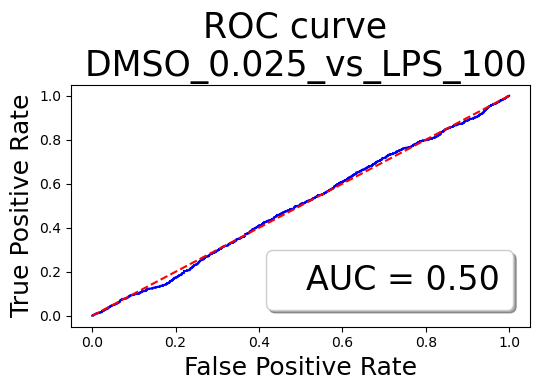

In [26]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [27]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_test",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3081
           1       0.27      0.27      0.27      1186

    accuracy                           0.60      4267
   macro avg       0.50      0.50      0.50      4267
weighted avg       0.60      0.60      0.60      4267



In [28]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_1708492/3173912586.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the hold out wells

In [29]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [30]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

DMSO_0.025_vs_LPS_100_shuffle
              precision    recall  f1-score   support

           0       0.53      0.58      0.55      4837
           1       0.45      0.40      0.42      4126

    accuracy                           0.50      8963
   macro avg       0.49      0.49      0.49      8963
weighted avg       0.49      0.50      0.49      8963



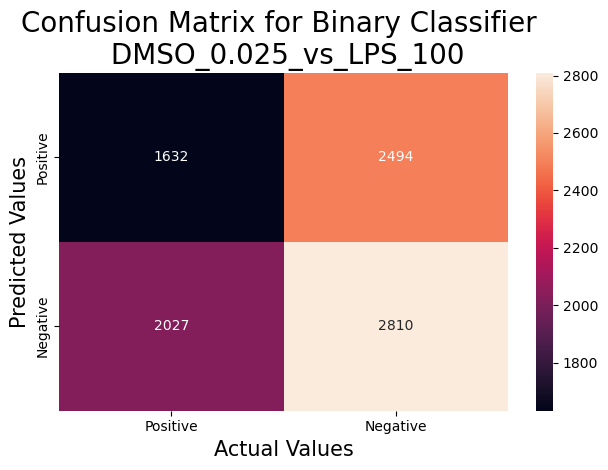

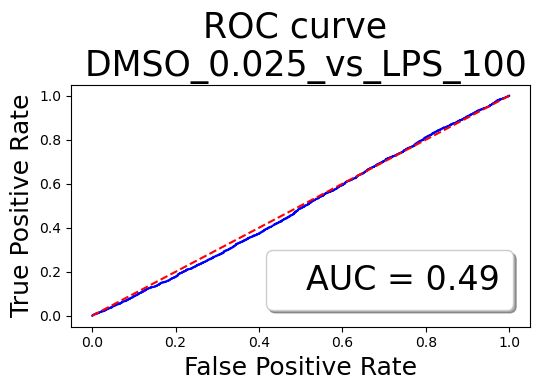

In [31]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [32]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    df_values_Y,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_hold_out",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.53      0.58      0.55      4837
           1       0.45      0.40      0.42      4126

    accuracy                           0.50      8963
   macro avg       0.49      0.49      0.49      8963
weighted avg       0.49      0.50      0.49      8963



In [33]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_1708492/1425043378.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [34]:
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall
0,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,train,True,0.0,0.278001,1.000000
1,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,train,True,0.0,0.278009,1.000000
2,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,train,True,0.0,0.278017,1.000000
3,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,train,True,0.0,0.278025,1.000000
4,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,train,True,0.0,0.278033,1.000000
...,...,...,...,...,...,...,...
8844,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.700000,0.001697
8845,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.666667,0.001454
8846,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.714286,0.001212
8847,DMSO_0.100_%_DMSO_0.025_% vs. LPS_100.000_ug_p...,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.833333,0.001212


In [35]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)

/tmp/ipykernel_1708492/4008283182.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
